# HW3

## Load and preprocess data

In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from subprocess import Popen, PIPE, STDOUT
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

#### load and plot one data chunk:

In [94]:
data_class = 2
data_dir = 3
data_file = 6

data_chunk = pd.read_csv('class_%d/dir_%d/raw_data/rd_%d.csv'%(data_class, data_dir, data_file), header=None)
peak_indices = np.genfromtxt('class_%d/dir_%d/frames/f_%d.csv'%(data_class, data_dir, data_file), delimiter=',')
# peak_indices

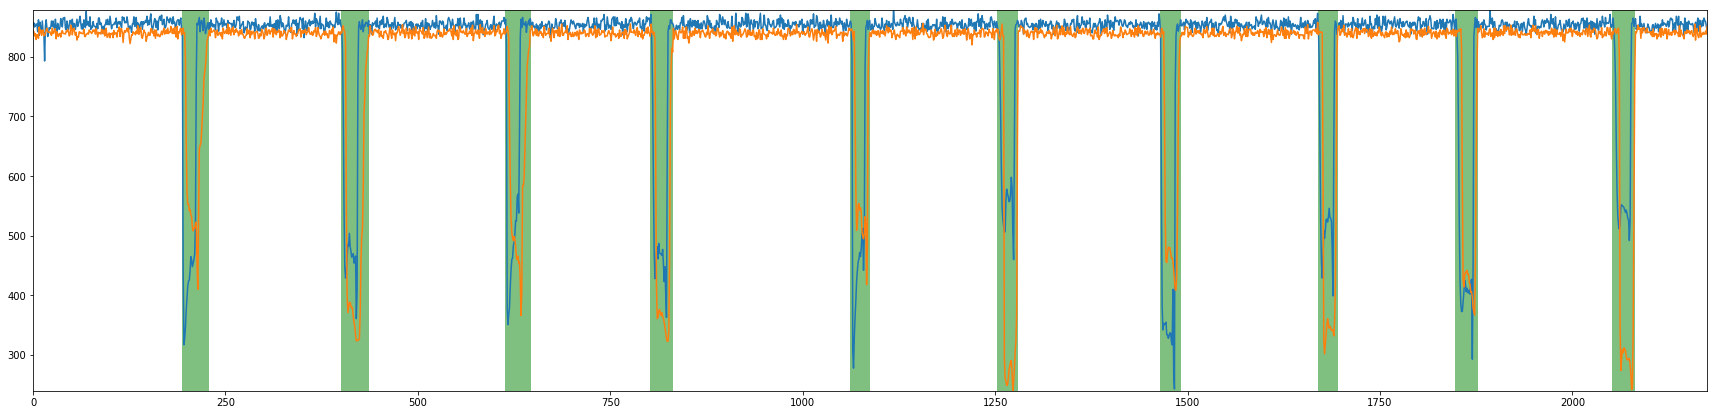

In [95]:
def plot_samples(peak_indices, data_chunk):    
    plt.figure(figsize=(30,7))
    ax = plt.gca()

    ax.margins(0)
    for interv in peak_indices:
        ax.axvspan(interv[0], interv[1], facecolor='green', alpha=0.5)

    data_chunk[0].plot()
    data_chunk[1].plot()
    plt.show()
    
plot_samples(peak_indices, data_chunk)    

### Create dataset

For more convenient work with data I extracted samples, standardised them to the length of the longest sample and created a dataset with the number of the class as a target variable.

In [118]:
# calculated lengths of samples
max_len_samp, mean_len_samp, min_len_samp = 79, 42.28721432983323, 11

In [119]:
def get_folder_content(folder_path):
    """returns names of all files in a folder"""
    out = Popen(['ls', folder_path], 
           stdout=PIPE, 
           stderr=STDOUT)
    stdout, stderr = out.communicate()
    files = stdout.decode().split('\n')
    files.remove('')
    return files

In [120]:
def write_data_in_df(gen_dir_path, class_num, use_given_samples=True):
    """returns dataframe with 2d-arrays as data"""
    raw_files = get_folder_content(gen_dir_path+'/raw_data')
    frame_files = get_folder_content(gen_dir_path+'/frames')
    df=pd.DataFrame()
    for rd, f in zip(raw_files, frame_files):
        
        raw_data = np.genfromtxt(gen_dir_path+'/raw_data/'+rd, delimiter=',')
        if use_given_samples:
            frames = np.genfromtxt(gen_dir_path+'/frames/'+f, delimiter=',')
        else:
            frames = get_samples(raw_data)
        for interv in frames:
            df = df.append(pd.DataFrame([[raw_data[int(interv[0]):int(interv[1]+1)],  class_num]]), ignore_index=True)
    return df

In [121]:
def load_data(use_given_samples=True):
    """returns trainable dataset, target and max, mean, min lengthes of samples in dataset"""
    samples = pd.DataFrame()
    for i in (1,2,3): 
        dirs = get_folder_content('class_' + str(i))
        for d in dirs:
            samples = samples.append(write_data_in_df('class_%d/%s'%(i, d), i, use_given_samples=use_given_samples), ignore_index=True)
    samples.head()
    
    # add zeros to standardize the data and store it in trainable way
    data = pd.DataFrame()
    for samp in samples[0]:
        dif = max_len_samp - samp.shape[0]
        if dif<0:
            reshaped = np.concatenate((samp[:max_len_samp,0], samp[:max_len_samp,1]))
        else:                             
            reshaped = np.concatenate((samp[:,0], [0]*dif, samp[:,1], [0]*dif))
        data = data.append(pd.DataFrame([reshaped]), ignore_index=True)

    target = samples[1]
    del samples
    
    return data, target

In [122]:
data, target = load_data()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
0,852.0,852.0,847.0,829.0,359.0,347.0,731.0,849.0,839.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,848.0,851.0,853.0,839.0,383.0,269.0,285.0,319.0,346.0,433.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,857.0,850.0,852.0,858.0,780.0,291.0,225.0,254.0,776.0,852.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,863.0,846.0,845.0,849.0,735.0,302.0,242.0,240.0,257.0,273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,855.0,843.0,850.0,850.0,857.0,579.0,345.0,318.0,317.0,321.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Detect samples

In [123]:
def cut_straight(single_data):
    """calculates a threshold for 1-d array
    and returns a boolean mask if values are <= that treshold """
    std = np.std(single_data[single_data>=820])
    threshold = np.mean(single_data[single_data>=820]) - 9*std
    return single_data <= threshold

In [124]:
def nonzero_intervals(vec):
    """returns coordinates of nonzero islands in an array"""
    if len(vec)==0:
        return []
    elif not isinstance(vec, np.ndarray):
        vec = np.array(vec)

    edges, = np.nonzero(np.diff((vec==0)*1))
    edge_vec = [edges+1]
    if vec[0] != 0:
        edge_vec.insert(0, [0])
    if vec[-1] != 0:
        edge_vec.append([len(vec)])
    edges = np.concatenate(edge_vec)
    return np.array(list(zip(edges[::2], edges[1::2])))

In [125]:
def get_peaks(raw_data):
    """returns coords of peaks in raw data and 1d-mask for 2d-array data"""
    mask_1 = cut_straight(raw_data[:, 0])
    mask_2 = cut_straight(raw_data[:, 1])
    
    gen_mask = np.zeros(mask_1.shape[0])
    gen_mask[mask_1] = 1
    gen_mask[mask_2] = 2
    gen_mask[np.logical_and(mask_1, mask_2)] = 3
    
    indices = nonzero_intervals(gen_mask)
            
    return indices, gen_mask

In [126]:
def get_samples(raw_data):
    """returns coords of the samples"""
    indices, gen_mask = get_peaks(raw_data)
    np.append(indices, [[0,0]])
    
    add_data = 4
    min_dist = 6
    
    for i in range(len(indices)-1):
        if 3 in gen_mask[indices[i][0]:indices[i][1]]:
            continue

        if (((3 not in gen_mask[indices[i][0]:indices[i][1]])or(3 not in gen_mask[indices[i+1][0]:indices[i+1][1]])) and (indices[i][1]-indices[i+1][0]<min_dist)) and indices[i+1][1]-indices[i][0]<max_len_samp:
            indices[i+1][0] = indices[i][0]
            indices[i] = [0,0]
            
        if ((3 in gen_mask[indices[i][0]:indices[i][1]]) and (indices[i][1]-indices[i+1][0]<2)) and indices[i+1][1]-indices[i][0]<max_len_samp:
            indices[i+1][0] = indices[i][0]
            indices[i] = [0,0]
    return np.array([[pair[0]-add_data, pair[1]+add_data] for pair in indices if 0 not in pair])

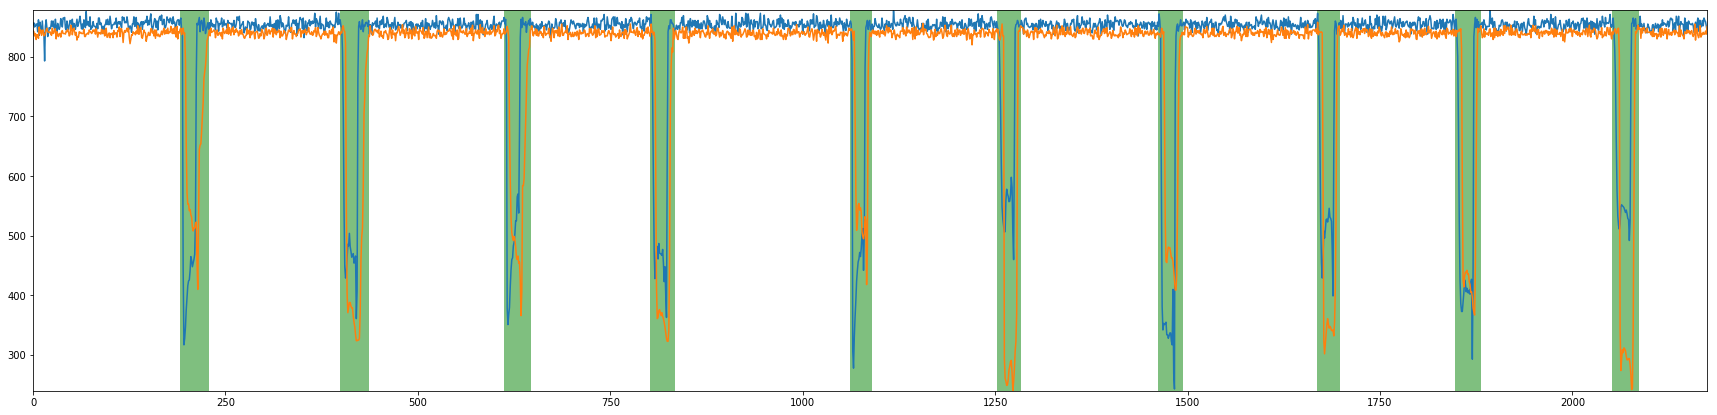

In [127]:
ind = get_samples(data_chunk.values)
plot_samples(ind, data_chunk)

## Training and model comparison

Multiple experiments showed that models perfotm better if an algorithm for sample detection is used on trainind set as well as on  testing set, so I construct dataset once again:

In [128]:
data, target = load_data(use_given_samples=False)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
0,852.0,852.0,847.0,829.0,359.0,347.0,731.0,849.0,839.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,848.0,851.0,853.0,839.0,383.0,269.0,285.0,319.0,346.0,433.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,847.0,847.0,832.0,800.0,777.0,787.0,822.0,830.0,848.0,849.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,863.0,846.0,845.0,849.0,735.0,302.0,242.0,240.0,257.0,273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,843.0,850.0,850.0,857.0,579.0,345.0,318.0,317.0,321.0,326.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
train_x, test_x, train_y, test_y = train_test_split(data, target)

In [130]:
lr_clf = LogisticRegression()
lr_clf.fit(train_x, train_y)
lr_train_pred = lr_clf.predict(train_x)
lr_test_pred = lr_clf.predict(test_x)
accuracy_score(train_y, lr_train_pred), accuracy_score(test_y, lr_test_pred)

(0.8735271013354281, 0.7647058823529411)

In [131]:
et_clf = ExtraTreesClassifier()
et_clf.fit(train_x, train_y)
et_train_pred = et_clf.predict(train_x)
et_test_pred = et_clf.predict(test_x)
accuracy_score(train_y, et_train_pred), accuracy_score(test_y, et_test_pred)

(1.0, 0.8870588235294118)

In [132]:
# I know it won`t work, just for comparison
svm_clf = SVC()
svm_clf.fit(train_x, train_y)
svm_train_pred = svm_clf.predict(train_x)
svm_test_pred = svm_clf.predict(test_x)
accuracy_score(train_y, svm_train_pred), accuracy_score(test_y, svm_test_pred)

(1.0, 0.35764705882352943)

In [133]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_x, train_y)
xgb_train_pred = xgb_clf.predict(train_x)
xgb_test_pred = xgb_clf.predict(test_x)
accuracy_score(train_y, xgb_train_pred), accuracy_score(test_y, xgb_test_pred)

/home/marytem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marytem/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.997643362136685, 0.9317647058823529)

### Testing on unlabeled data

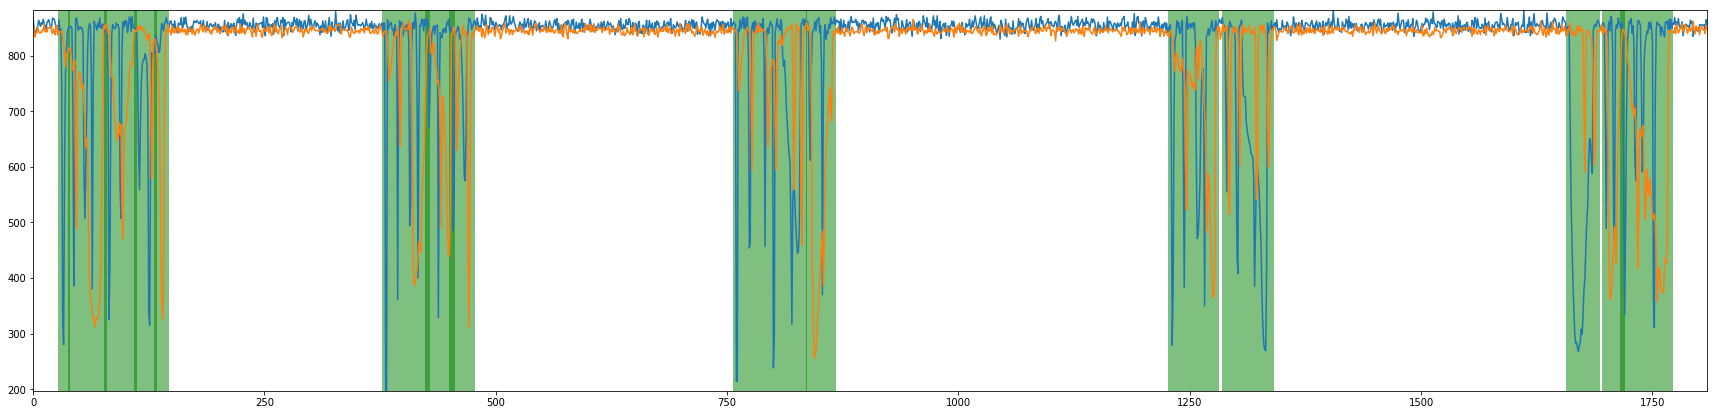

In [134]:
exp_data = pd.read_csv('experiment_mixed_data/4_frames_one_after_another/raw_data/rd_3.csv', header=None)
exp_ind = get_samples(exp_data.values)
plot_samples(exp_ind, exp_data)

In [135]:
df = write_data_in_df('experiment_mixed_data/4_frames_one_after_another', 4, use_given_samples=False)

data = pd.DataFrame()
for samp in df[0]:
    dif = max_len_samp - samp.shape[0]
    if dif<0:
        reshaped = np.concatenate((samp[:max_len_samp,0], samp[:max_len_samp,1]))
    else:                             
        reshaped = np.concatenate((samp[:,0], [0]*dif, samp[:,1], [0]*dif))
    data = data.append(pd.DataFrame([reshaped]), ignore_index=True)
del df

data.head()

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
0,859.0,864.0,844.0,838.0,632.0,445.0,542.0,713.0,766.0,779.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,842.0,839.0,847.0,817.0,565.0,672.0,848.0,853.0,853.0,857.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,852.0,870.0,861.0,839.0,494.0,313.0,317.0,387.0,446.0,579.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,876.0,848.0,847.0,858.0,688.0,417.0,348.0,447.0,561.0,693.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,811.0,860.0,862.0,809.0,599.0,524.0,501.0,581.0,603.0,637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
pred = et_clf.predict(data)
pred

array([3, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1])

## Resuts

Of all types of models, trees ensembles have the best performance because of their decision border - it is flexible enough for this task. As usual XGBoostClassifier outperforms the rest, therefore lets look at its performance closely.

In [137]:
accuracy_score(train_y, xgb_train_pred), accuracy_score(test_y, xgb_test_pred)

(0.997643362136685, 0.9317647058823529)

In [138]:
# confuses 3 and 1 
confusion_matrix(test_y, xgb_test_pred)

array([[129,   0,   7],
       [  1, 149,   2],
       [ 17,   2, 118]])

In [139]:
print(classification_report(test_y, xgb_test_pred))

             precision    recall  f1-score   support

          1       0.88      0.95      0.91       136
          2       0.99      0.98      0.98       152
          3       0.93      0.86      0.89       137

avg / total       0.93      0.93      0.93       425

